In [1]:
import numpy as np
import random
import math
import time
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import scipy.io
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers
from datetime import datetime, timedelta
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm import tqdm

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import datetime


/home/vivivorropoulou/Transformer_Diffusion_Model_RUL_Battery_Prediction/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# convert str to datatime 
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# get capacity data
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# get the charge data of a battery
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [4]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = 'datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    Battery[name] = getBatteryCapacity(data)

Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


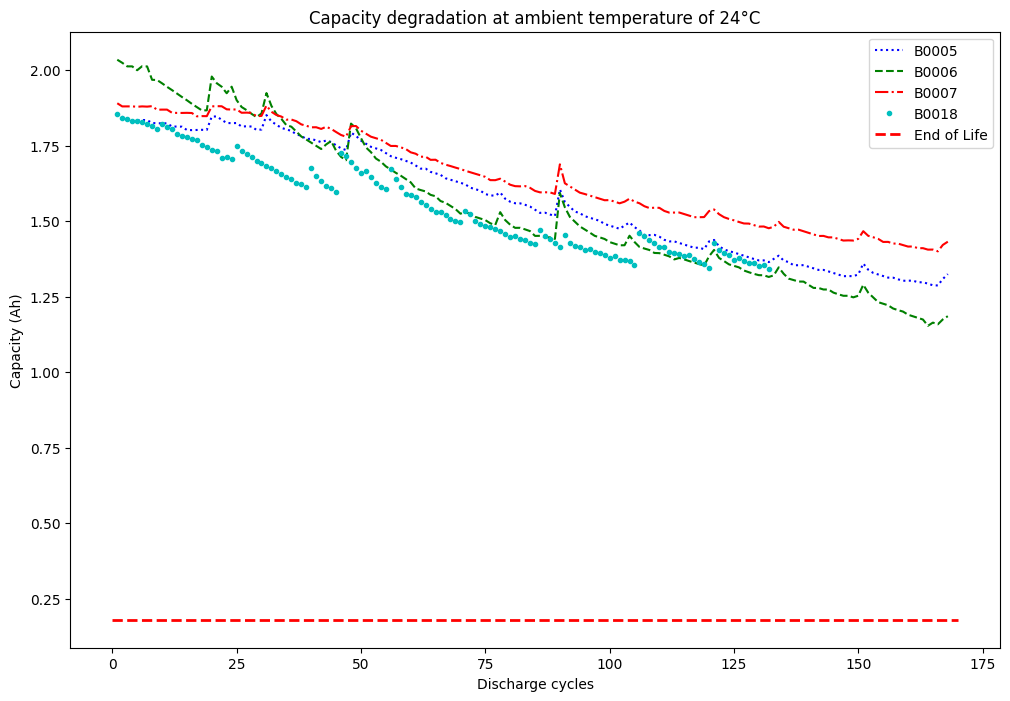

In [5]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
#EOL: Battery reaches 80% of capacity
EOL = ax.hlines(y=0.18,xmin = 0, xmax = 170, linewidth=2, color='r', linestyles = 'dashed', label='End of Life')
plt.legend()

In [6]:
def build_instances(sequence, window_size):
    #sequence: list of capacity
    x, y = [],[]
    for i in range(len(sequence) - window_size):
        features = sequence[i:i+window_size]
        target = sequence[i+window_size]

        x.append(features)
        y.append(target)
        
    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)


def split_dataset(data_sequence, train_ratio=0.0, capacity_threshold=0.0):
    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        capacity = max_capacity * capacity_threshold
        point = [i for i in range(len(data_sequence)) if data_sequence[i] < capacity]
    else:
        point = int(train_ratio + 1)
        if 0 < train_ratio <= 1:
            point = int(len(data_sequence) * train_ratio)
    train_data, test_data = data_sequence[:point], data_sequence[point:]
    
    return train_data, test_data


def get_train_test(data_dict, name, window_size=8, train_ratio=0.7, validation_ratio=0.2):
    # Ensure the sum of train_ratio and validation_ratio leaves some data for testing
    if train_ratio + validation_ratio >= 1:
        raise ValueError("Sum of train_ratio and validation_ratio must be less than 1.")

    data_sequence = data_dict[name][1]
    # Calculate indices for data splitting
    train_end = int(len(data_sequence) * train_ratio)
    valid_end = int(len(data_sequence) * (train_ratio + validation_ratio))

    # Split data
    train_data = data_sequence[:train_end]
    valid_data = data_sequence[train_end:valid_end]
    test_data = data_sequence[valid_end:]

    # Build sequences for training data
    train_x, train_y = build_instances(text=train_data, window_size=window_size)

    # Build sequences for validation data
    valid_x, valid_y = build_instances(text=valid_data, window_size=window_size)

    # Build sequences for test data
    test_x, test_y = build_instances(text=test_data, window_size=window_size)

    # Gather additional training data from other keys in the dictionary
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_instances(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    # Return structured data
    print(list(train_data))
    return train_x, train_y, valid_x, valid_y, test_x, test_y, list(train_data), list(valid_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
            
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
            
    score = abs(true_re - pred_re)/true_re
    if score > 1: score = 1
        
    return score


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse

In [7]:
import torch.nn.functional as F

def Conv1d_with_init(in_channels, out_channels, kernel_size, device):
    layer = nn.Conv1d(in_channels, out_channels, kernel_size).to(device)
    nn.init.kaiming_normal_(layer.weight)
    
    return layer

class TimeEmbedding(nn.Module):
    def __init__(self, tp, d_model, device):
        super().__init__()
        self.device = device
        self.register_buffer('time_embedding', self._build_embedding(tp + 1, d_model), persistent=False)
    
    def forward(self, m):
        return self.time_embedding[m]
    
    def _build_embedding(self, t, d_model):
        pe = torch.zeros(t, d_model).to(self.device)
        position = torch.arange(t).unsqueeze(1).to(self.device)
        div_term = (1 / torch.pow(10000.0, torch.arange(0, d_model, 2) / d_model)).to(self.device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe

class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim, device):
        super().__init__()
        self.device = device
        self.register_buffer('diffusion_embedding', self._build_embedding(num_steps, embedding_dim / 2), persistent=False)
        self.projection1 = nn.Linear(embedding_dim, embedding_dim).to(device)
        self.projection2 = nn.Linear(embedding_dim, embedding_dim).to(device)
        
    def forward(self, diffusion_step):
        x = self.diffusion_embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        
        return x
    
    def _build_embedding(self, num_steps, dim):
        steps = torch.arange(num_steps).unsqueeze(1).to(self.device)
        frequencies = (10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)).to(self.device)
        table = steps * frequencies
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
        
        return table

class ResNet(nn.Module):
    def __init__(self, config, device):
            super().__init__()
            var, target_var = pickle.load(open('preprocess/data/var.pkl', 'rb'))
            lv = len(var)
            self.size_x = config['size']
            self.size_y = 10 * len(target_var)
            self.channels = config['channels']
            self.emb_f = nn.Embedding(lv + 1, self.channels).to(device)
            self.emb_t = TimeEmbedding(config['time_points'], config['time_embedding_dim'], device)
            self.emb_v = nn.Linear(1, self.channels).to(device)
            self.dec1 = Conv1d_with_init(self.channels, self.channels, 1, device)
            self.dec2 = Conv1d_with_init(self.channels, 1, 1, device)
            self.diffusion_embedding = DiffusionEmbedding(config['num_steps'], config['diffusion_embedding_dim'], device)
            self.diffusion_projection = nn.Linear(config['diffusion_embedding_dim'], self.channels).to(device)
            self.residual_layers = nn.ModuleList([
                Triplet_cor(config, lv, device)
                for _ in range(config['layers'])])
            
    def forward(self, samples_x, samples_y, info, diffusion_step):
        diffusion_emb = self.diffusion_embedding(diffusion_step)
        diffusion_emb = self.diffusion_projection(diffusion_emb)
        diffusion_emb = diffusion_emb.unsqueeze(1).expand(diffusion_emb.shape[0], self.size_x, diffusion_emb.shape[1])
        triplets_x = (self.emb_f(samples_x[:, 0].to(torch.int64))
                    + self.emb_t(samples_x[:, 1].to(torch.int64))
                    + self.emb_v(samples_x[:, 2].unsqueeze(-1))
                    + diffusion_emb) * samples_x[:, 3].unsqueeze(-1)
        triplets_y = (self.emb_f(samples_y[:, 0].to(torch.int64))
                    + self.emb_t(samples_y[:, 1].to(torch.int64))
                    + self.emb_v(samples_y[:, 2].unsqueeze(-1))
                    ) * samples_y[:, 3].unsqueeze(-1)
        diffussion_emb_y = diffusion_emb[:, : self.size_y] * samples_y[:, 3].unsqueeze(-1)
        skip = []
        for layer in self.residual_layers:
            triplets_y = triplets_y + diffussion_emb_y
            triplets_y, skip_connection = layer(triplets_x, triplets_y)
            skip.append(skip_connection)
            
        output = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        output = self.dec1(output.permute(0, 2, 1))
        output = F.relu(output)
        output = self.dec2(output)
        
        return output.squeeze()

class Triplet_cor(nn.Module):
    def __init__(self, config, lv, device):
        super().__init__()
        self.channels = config['channels']
        self.attn = torch.nn.Transformer(d_model=self.channels, nhead=8, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=256, dropout=0.1, activation='gelu', batch_first=True, device=device)
        self.expand = Conv1d_with_init(self.channels, 2 * self.channels, 1, device)
    
    def forward(self, triplets_x, triplets_y):
        output = self.attn(triplets_x, triplets_y)
        output = self.expand(output.transpose(1, 2)).transpose(1, 2)
        residual, skip = torch.chunk(output, 2, dim=-1)
        
        return residual, skip

In [8]:
class diffusion(nn.Module):
    def __init__(self, config, device):
        super().__init__() # ensure that the diffusion model properly inherits all the functionality of a pytorch module
        self.device = device # where will the model run (cpu or gpu)
        self.config_diff = config['diffusion'] # settings for diffusion model 
        var, _ = pickle.load(open('preprocess/data/var.pkl', 'rb')) # preprocessing 
        self.lv = len(var)
        self.res_model = ResNet(self.config_diff, self.device) # part of the transformer for sequence processing
        # parameters for diffusion model
        self.num_steps = self.config_diff['num_steps'] # number of steps
        self.beta = np.linspace(self.config_diff['beta_start'] ** 0.5, self.config_diff['beta_end'] ** 0.5, self.num_steps) ** 2 # generation of beta values
        self.alpha_hat = 1 - self.beta # scale of the noise added at each step 
        self.alpha = np.cumprod(self.alpha_hat)
        self.alpha_torch = torch.tensor(self.alpha).float().to(self.device).unsqueeze(1)  # convertion to pytorch tensor 

    def process(self, batch): # prepare the input batch data for further processing by the model 
        samples_x = batch['samples_x'].to(self.device).float() # transfers batch data samples x to device and converts to float 
        samples_y = batch['samples_y'].to(self.device).float() # transfers batch data samples y to device and converts to float 
        info = batch['info'].to(self.device) # transfers batch info data to device
        
        return samples_x, samples_y, info

    def forward(self, batch, size_x, size_y): # forward pass of the model 
        samples_x, samples_y, info = self.process(batch) # process input batch 
        t = torch.randint(0, self.num_steps, [len(samples_x)]).to(self.device) # generate tensor t of random ints (time steps for diffusion process) and the length of samples x
        current_alpha = self.alpha_torch[t] # selection of corresponding alpha value for each sample to scale samples y 
        noise = torch.randn((len(samples_x), size_y)).to(samples_y.device) # generation of random noise added to samples y ans ensured zthat its on the same device
        mask_x = samples_x[:, 3] # indicate which elements in samples x and y should be considered during certain operations
        mask_y = samples_y[:, 3]
        samples_x[:, 0] = torch.where(mask_x == 1, samples_x[:, 0], self.lv) # handling missing data 
        samples_x[:, 1] = torch.where(mask_x == 1, samples_x[:, 1], -1)
        samples_y[:, 0] = torch.where(mask_y == 1, samples_y[:, 0], self.lv)
        samples_y[:, 1] = torch.where(mask_y == 1, samples_y[:, 1], -1)
        samples_y[:, 2] = ((current_alpha ** 0.5) * samples_y[:, 2] + ((1.0 - current_alpha) ** 0.5) * noise) * mask_y # weighted sum of the original samples y and the generated noise (eq. page 5 last line) modified by mask
        predicted = self.res_model(samples_x, samples_y, info, t) # prediction
        residual = torch.where(mask_y == 1, noise - predicted, 0) # 
        loss = (residual ** 2).sum() / info[:, 2].sum() # 

        return loss

    def forecast(self, samples_x, samples_y, info, n_samples): # reverse diffusion process / prediction over n samples 
        generation = torch.zeros(n_samples, samples_y.shape[0], samples_y.shape[-1]).to(self.device) # storing the gerated forecasts 
        for i in range(n_samples): # iterate thorugh every sample
            samples_y[:, 2] = torch.randn_like(samples_y[:, 2]) * samples_y[:, 3] # initializing with random noise 
            for t in range(self.num_steps - 1, -1, -1): # iterate over diffusion steps , reverse diffusion process
                mask_x = samples_x[:, 3]
                mask_y = samples_y[:, 3]
                samples_x[:, 0] = torch.where(mask_x == 1, samples_x[:, 0], self.lv)
                samples_x[:, 1] = torch.where(mask_x == 1, samples_x[:, 1], -1)
                samples_y[:, 0] = torch.where(mask_y == 1, samples_y[:, 0], self.lv)
                samples_y[:, 1] = torch.where(mask_y == 1, samples_y[:, 1], -1)
                predicted = self.res_model(samples_x, samples_y, info, torch.tensor([t]).to(self.device)) # prediction
                # Denoising operation 
                coeff1 = 1 / self.alpha_hat[t] ** 0.5 # coefficient equation (3)
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5 # coefficient equation (3) with beta = 1 - alpha_hat
                samples_y[:, 2] = coeff1 * (samples_y[:, 2] - coeff2 * predicted) * samples_y[:, 3] # equation (3)
                if t > 0:
                    noise = torch.randn_like(samples_y[:, 2]) * samples_y[:, 3] # epsilon = N(0,I)
                    sigma = ((1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]) ** 0.5 # equation (4)
                    samples_y[:, 2] += sigma * noise

            generation[i] = samples_y[:, 2].detach()
            
        return generation.permute(1, 2, 0)

    def evaluate(self, batch, n_samples):
        samples_x, samples_y, info = self.process(batch)
        with torch.no_grad():
            generation = self.forecast(samples_x, samples_y, info, n_samples)
            
        return generation, samples_y, samples_x

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import pandas as pd
def get_dataloader(battery_data, batch_size=32):
    # Assume battery_data is a DataFrame with columns: 'Cycle_Index', 'Voltage', 'Temp', 'Discharge_Capacity'
    all_data = battery_data
    
    # Define the features and the target variable according to the analysis goal
    X = all_data[['cycle', 'capacity', 'SoH', 'resistance', 'CCCT', 'CVCT']].values  # Example feature columns
    y = all_data['capacity'].values  # Assuming we're predicting capacity directly

    # Convert data to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Create a TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Split the dataset into training, validation, and testing
    train_size = int(0.7 * len(dataset))
    valid_size = int(0.15 * len(dataset))
    test_size = len(dataset) - (train_size + valid_size)
    train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

    # Create DataLoader for each set
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

In [ ]:
def train(
    model,
    config,
    train_loader,
    valid_loader=None,
    valid_epoch_interval=10,
    foldername='',
):
    optimizer = Adam(model.parameters(), lr=config['train']['lr'], weight_decay=5e-8)
    if foldername != '':
        output_path = foldername + '/model.pth'
    m = []
    for i in range(int(config['train']['epochs'] / 10)):
        m.append(i * 10)
        
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=m[1:], gamma=0.8)
    ct = 0
    
    battery = BatteryDataPreprocessor(dir_path, battery_list)
    target_var = battery.load_calce_datasets()
    size_y = 10 * len(target_var)
    best_valid_loss = np.inf
    for epoch_no in range(config['train']['epochs']):
        avg_loss = 0
        model.train()
        with tqdm(train_loader, mininterval=5.0, maxinterval=50.0) as it:
            for batch_no, train_batch in enumerate(it, start=1):
                optimizer.zero_grad()
                loss = model(train_batch, config['diffusion']['size'], size_y)
                loss.backward()
                avg_loss += loss.item()
                optimizer.step()
                it.set_postfix(
                    ordered_dict={
                        'avg_epoch_loss': avg_loss / batch_no,
                        'epoch': epoch_no,
                        'lr': optimizer.param_groups[0]['lr']
                    },
                    refresh=False,
                )
                
            lr_scheduler.step()
        if valid_loader is not None and (epoch_no + 1) % valid_epoch_interval == 0 and epoch_no > 135:
            model.eval()
            CRPS_valid, _ = evaluate(0, model, valid_loader, nsample=5, foldername=foldername)
            print('{} (best)'.format(round(best_valid_loss, 4)))
            print('{} (current)'.format(round(CRPS_valid, 4)))
            if best_valid_loss > CRPS_valid:
                ct = 0
                best_valid_loss = CRPS_valid
                torch.save(model.state_dict(), output_path)
                print('model updated')
            else:
                ct += 1
                print('count: {}'.format(ct))
            # earlystopping
            if ct > 2:
                model.load_state_dict(torch.load(output_path))
                print('stop')
                break
            
def calc_metrics(is_test, all_generation, all_samples_y):
    MSE = None
    target = all_samples_y[:, 2]
    if is_test == 1:
        quantiles = np.arange(0.05, 1.0, 0.05)
        # calculate MSE
        gt = all_samples_y[:, 2]
        mask = all_samples_y[:, 3]
        prediction = all_generation.median(dim=2)
        MSE = ((prediction.values - gt) * mask) ** 2
        MSE = MSE.sum() / mask.sum()
    else:
        quantiles = np.arange(0.25, 1.0, 0.25)
    denom = torch.sum(torch.abs(target))
    CRPS = 0
    for i in range(len(quantiles)):
        q_pred = []
        for j in range(len(all_generation)):
            q_pred.append(torch.quantile(all_generation[j], quantiles[i], dim = -1))
        q_pred = torch.cat(q_pred, 0).reshape(-1)
        target = target.reshape(-1)
        q_loss = 2 * torch.sum(torch.abs((q_pred - target) * all_samples_y[:, 3].reshape(-1) * ((target <= q_pred) * 1.0 - quantiles[i])))
        CRPS += q_loss / denom

    return CRPS.item() / len(quantiles), MSE

def evaluate(is_test, model, data_loader, nsample=100, foldername=""):
    with torch.no_grad():
        model.eval()
        all_samples_x = []
        all_samples_y = []
        all_generation = []
        with tqdm(data_loader, mininterval=5.0, maxinterval=50.0) as it:
            for batch_no, batch in enumerate(it, start=1):
                # ground truth values will be replaced with pure noise before generation
                output = model.evaluate(batch, nsample)
                generation, samples_y, samples_x = output
                all_generation.append(generation)
                all_samples_x.append(samples_x)
                all_samples_y.append(samples_y)
            
            all_generation = torch.cat(all_generation)
            all_samples_x = torch.cat(all_samples_x)
            all_samples_y = torch.cat(all_samples_y)
            CRPS, MSE = calc_metrics(is_test, all_generation, all_samples_y)
            if is_test == 1:
                pickle.dump([all_generation, all_samples_y, all_samples_x], open(foldername + "/generated_outputs" + str(nsample) + ".pkl", "wb"))
                pickle.dump([CRPS, MSE], open(foldername + "/result_nsample" + str(nsample) + ".pkl", "wb"))
    return CRPS, MSE